In [1]:
import datetime as dt
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV,KFold, cross_val_score
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error, r2_score, make_scorer
from sklearn.tree import plot_tree


# Čistenie

In [2]:
df = pd.read_csv("macro-economic-db-quarterly.csv", delimiter=";", index_col=0)
df = df.transpose()

df.reset_index(inplace=True)
df.rename(columns={"index":"stvrtrok"}, inplace=True)
for column in df.columns[1:]:
    df[column] = df[column].str.replace(",", "").astype(float)

columns_to_modify = df.columns.difference(["urok"])
df[columns_to_modify] = df[columns_to_modify].replace(0, np.nan)

df["bilancia"] = df.vyvoz - df.dovoz

df["NaN_Percentage"] = df.isna().sum(axis=1) / df.shape[1] * 100
df_cut =  df[df["NaN_Percentage"] <= 30].drop(columns=["NaN_Percentage"])
df_cut.reset_index(drop=True, inplace=True)

df_clean = df_cut.bfill()
df_clean = df_clean.ffill()

In [13]:
import pandas as pd

# Load your dataset (assuming it's in a CSV file)


# Calculate Pearson correlation between GDP (HDP) and Labor Force (Pracovná sila)
correlation = df_clean["cpi"].corr(df_clean["ppi"])
print("Pearson Correlation:", correlation)


Pearson Correlation: 0.8859317688472544


# Modelovanie

In [3]:
#Rozdelenie dát

#HDP
X_hdp = df_clean[df_clean.columns.difference(["hdp", "stvrtrok"])]
y_hdp = df_clean.hdp
X_train_hdp, X_test_hdp, y_train_hdp, y_test_hdp = train_test_split(X_hdp, y_hdp, test_size=0.2, random_state=42)


#Nezamestnanosť
X_nezamestnanost = df_clean[df_clean.columns.difference(["nezamestnanost", "stvrtrok"])]
y_nezamestnanost = df_clean.nezamestnanost
X_train_nezamestnanost, X_test_nezamestnanost, y_train_nezamestnanost, y_test_nezamestnanost = train_test_split(X_nezamestnanost, y_nezamestnanost, test_size=0.2, random_state=42)


#Inflácia
X_cpi = df_clean[df_clean.columns.difference(["cpi", "stvrtrok"])]
y_cpi = df_clean.cpi
X_train_cpi, X_test_cpi, y_train_cpi, y_test_cpi = train_test_split(X_cpi, y_cpi, test_size=0.2, random_state=42)


In [4]:
#Rozhodovací strom pre HDP

dt_model_hdp = DecisionTreeRegressor(random_state=42)


param_grid_hdp = {
    'max_depth': [2, 3, 4, 5, 6, 8, 10, 12, None],
    'min_samples_split': [2, 5, 10, 15],
    'min_samples_leaf': [1, 2, 4, 6],
    'max_features': ['sqrt', 'log2', None],
    'criterion': ['squared_error', 'absolute_error']
}
mape_scorer = make_scorer(mean_absolute_percentage_error, greater_is_better=False)

grid_search_hdp = GridSearchCV(
    estimator=dt_model_hdp,
    param_grid=param_grid_hdp,
    cv=5,  
    scoring=mape_scorer,
    n_jobs=-1
)


grid_search_hdp.fit(X_train_hdp, y_train_hdp)


best_params_hdp = grid_search_hdp.best_params_
best_model_hdp = grid_search_hdp.best_estimator_

print("Najlepšie hyperparametre:", best_params_hdp)


y_pred_hdp = best_model_hdp.predict(X_test_hdp)
mae_hdp = mean_absolute_error(y_test_hdp, y_pred_hdp)
mse_hdp = mean_squared_error(y_test_hdp, y_pred_hdp)
rmse_hdp = np.sqrt(mse_hdp)
mape_hdp = mean_absolute_percentage_error(y_test_hdp, y_pred_hdp)
r2_hdp = r2_score(y_test_hdp, y_pred_hdp)

print(f"(MAE): {mae_hdp}")
print(f"(MSE): {mse_hdp}")
print(f"(RMSE): {rmse_hdp}")
print(f"(MAPE): {mape_hdp}")
print(f"R²: {r2_hdp}")


Najlepšie hyperparametre: {'criterion': 'squared_error', 'max_depth': 8, 'max_features': None, 'min_samples_leaf': 1, 'min_samples_split': 2}
(MAE): 216.93970869565254
(MSE): 71421.28553723659
(RMSE): 267.2476109102504
(MAPE): 0.01332572489481608
R²: 0.9972925884856688


In [5]:
#Rozhodovací strom pre nezamestnanosť

dt_model_nezamestnanost = DecisionTreeRegressor(random_state=42)


param_grid_nezamestnanost = {
    'max_depth': [2, 3, 4, 5, 6, 8, 10, 12, None],
    'min_samples_split': [2, 5, 10, 15],
    'min_samples_leaf': [1, 2, 4, 6],
    'max_features': ['sqrt', 'log2', None],
    'criterion': ['squared_error', 'absolute_error']
}
mape_scorer = make_scorer(mean_absolute_percentage_error, greater_is_better=False)


grid_search_nezamestnanost = GridSearchCV(
    estimator=dt_model_nezamestnanost,
    param_grid=param_grid_nezamestnanost,
    cv=5,  
    scoring=mape_scorer,
    n_jobs=-1  
)


grid_search_nezamestnanost.fit(X_train_nezamestnanost, y_train_nezamestnanost)


best_params_nezamestnanost = grid_search_nezamestnanost.best_params_
best_model_nezamestnanost = grid_search_nezamestnanost.best_estimator_

print("Najlepšie hyperparametre:", best_params_nezamestnanost)


y_pred_nezamestnanost = best_model_nezamestnanost.predict(X_test_nezamestnanost)
mae_nezamestnanost = mean_absolute_error(y_test_nezamestnanost, y_pred_nezamestnanost)
mse_nezamestnanost = mean_squared_error(y_test_nezamestnanost, y_pred_nezamestnanost)
rmse_nezamestnanost = np.sqrt(mse_nezamestnanost)
mape_nezamestnanost = mean_absolute_percentage_error(y_test_nezamestnanost, y_pred_nezamestnanost)
r2_nezamestnanost = r2_score(y_test_nezamestnanost, y_pred_nezamestnanost)

print(f"(MAE): {mae_nezamestnanost}")
print(f"(MSE): {mse_nezamestnanost}")
print(f"(RMSE): {rmse_nezamestnanost}")
print(f"(MAPE): {mape_nezamestnanost}")
print(f"R²: {r2_nezamestnanost}")



Najlepšie hyperparametre: {'criterion': 'absolute_error', 'max_depth': 12, 'max_features': None, 'min_samples_leaf': 1, 'min_samples_split': 2}
(MAE): 0.7056652173913041
(MSE): 1.2182741952173908
(RMSE): 1.1037545901229089
(MAPE): 0.056408424655902976
R²: 0.9197987533314965


In [6]:
#Rozhodovací strom pre infláciu

dt_model_cpi = DecisionTreeRegressor(random_state=42)


param_grid_cpi = {
    'max_depth': [2, 3, 4, 5, 6, 8, 10, 12, None],
    'min_samples_split': [2, 5, 10, 15],
    'min_samples_leaf': [1, 2, 4, 6],
    'max_features': ['sqrt', 'log2', None],
    'criterion': ['squared_error', 'absolute_error']
}
mape_scorer = make_scorer(mean_absolute_percentage_error, greater_is_better=False)


grid_search_cpi = GridSearchCV(
    estimator=dt_model_cpi,
    param_grid=param_grid_cpi,
    cv=5,  
    scoring=mape_scorer,
    n_jobs=-1  
)


grid_search_cpi.fit(X_train_cpi, y_train_cpi)


best_params_cpi = grid_search_cpi.best_params_
best_model_cpi = grid_search_cpi.best_estimator_

print("Najlepšie hyperparametre:", best_params_cpi)


y_pred_cpi = best_model_cpi.predict(X_test_cpi)
mae_cpi = mean_absolute_error(y_test_cpi, y_pred_cpi)
mse_cpi = mean_squared_error(y_test_cpi, y_pred_cpi)
rmse_cpi = np.sqrt(mse_cpi)
mape_cpi = mean_absolute_percentage_error(y_test_cpi, y_pred_cpi)
r2_cpi = r2_score(y_test_cpi, y_pred_cpi)

print(f"(MAE): {mae_cpi}")
print(f"(MSE): {mse_cpi}")
print(f"(RMSE): {rmse_cpi}")
print(f"(MAPE): {mape_cpi}")
print(f"R²: {r2_cpi}")




Najlepšie hyperparametre: {'criterion': 'absolute_error', 'max_depth': 6, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2}
(MAE): 2.2894369565217376
(MSE): 18.75038727445652
(RMSE): 4.330171737293629
(MAPE): 0.01795772803742377
R²: 0.9912955011458424


# Výsledky

In [13]:
#Hodnotiace metriky

metrics = {
    "Cieľová premenná": [
        "HDP",
        "Nezamestnanosť",
        "Inflácia"
    ],
    "MSE": [
        mse_hdp,
        mse_nezamestnanost,
        mse_cpi
    ],
    "MAE": [
        mae_hdp,
        mae_nezamestnanost,
        mae_cpi,
    ],
    "RMSE": [
        rmse_hdp,
        rmse_nezamestnanost,
        rmse_cpi
    ],
    "MAPE": [
        mape_hdp,
        mape_nezamestnanost,
        mape_cpi
    ],
    "R2": [
        r2_hdp,
        r2_nezamestnanost,
        r2_cpi
    ]
}

df_metrics = pd.DataFrame(metrics)
df_metrics

,Cieľová premenná,MSE,MAE,RMSE,MAPE,R2
0,HDP,71421.285537,216.939709,267.247611,0.013326,0.997293
1,Nezamestnanosť,1.218274,0.705665,1.103755,0.056408,0.919799
2,Inflácia,18.750387,2.289437,4.330172,0.017958,0.991296


In [ ]:
#Krížová validácia
target_vars = ["hdp", "nezamestnanost", "cpi"]


cv_results = []


kf = KFold(n_splits=5, shuffle=True, random_state=42)


mape_scorer = make_scorer(mean_absolute_percentage_error, greater_is_better=False)


for target in target_vars:
    print(f"\nCross-validation for target variable: {target}")

    
    X = eval(f"X_{target}")
    y = eval(f"y_{target}")

    
    model = eval(f"best_model_{target}")

    
    scores = cross_val_score(model, X, y, cv=kf, scoring=mape_scorer, n_jobs=-1)


    scores = np.abs(scores)

    
    cv_results.append({
        "Target Variable": target,
        "Mean MAPE": np.mean(scores),
        "Std MAPE": np.std(scores)
    })

    
    print(f"Mean MAPE: {np.mean(scores):.4f}")
    print(f"Std MAPE: {np.std(scores):.4f}")


cv_results_df = pd.DataFrame(cv_results)

cv_results_df


In [12]:
dfimp={
    "importance" :best_model_nezamestnanost.feature_importances_,
    "var": X_train_nezamestnanost.columns
 }

dfimp = pd.DataFrame(dfimp).sort_values(by="importance", ascending=False)

sum(dfimp.iloc[:3,0])


0.767726915435638

In [4]:
models = ["hdp", "nezamestnanost", "cpi"]
for target in models:  
        X = df_clean.drop(columns=[target, "stvrtrok"])
        print(X.columns)

Index(['nezamestnanost', 'pracovna_sila', 'obyvatelia', 'hicp', 'cpi', 'ppi',
       'nehnutelnosti', 'vladne_vydavky', 'tvorba_kapitalu', 'vyvoz', 'dovoz',
       'dlh', 'kurz_usd_eur', 'olej', 'urok', 'm2', 'bilancia'],
      dtype='object')
Index(['hdp', 'pracovna_sila', 'obyvatelia', 'hicp', 'cpi', 'ppi',
       'nehnutelnosti', 'vladne_vydavky', 'tvorba_kapitalu', 'vyvoz', 'dovoz',
       'dlh', 'kurz_usd_eur', 'olej', 'urok', 'm2', 'bilancia'],
      dtype='object')
Index(['hdp', 'nezamestnanost', 'pracovna_sila', 'obyvatelia', 'hicp', 'ppi',
       'nehnutelnosti', 'vladne_vydavky', 'tvorba_kapitalu', 'vyvoz', 'dovoz',
       'dlh', 'kurz_usd_eur', 'olej', 'urok', 'm2', 'bilancia'],
      dtype='object')


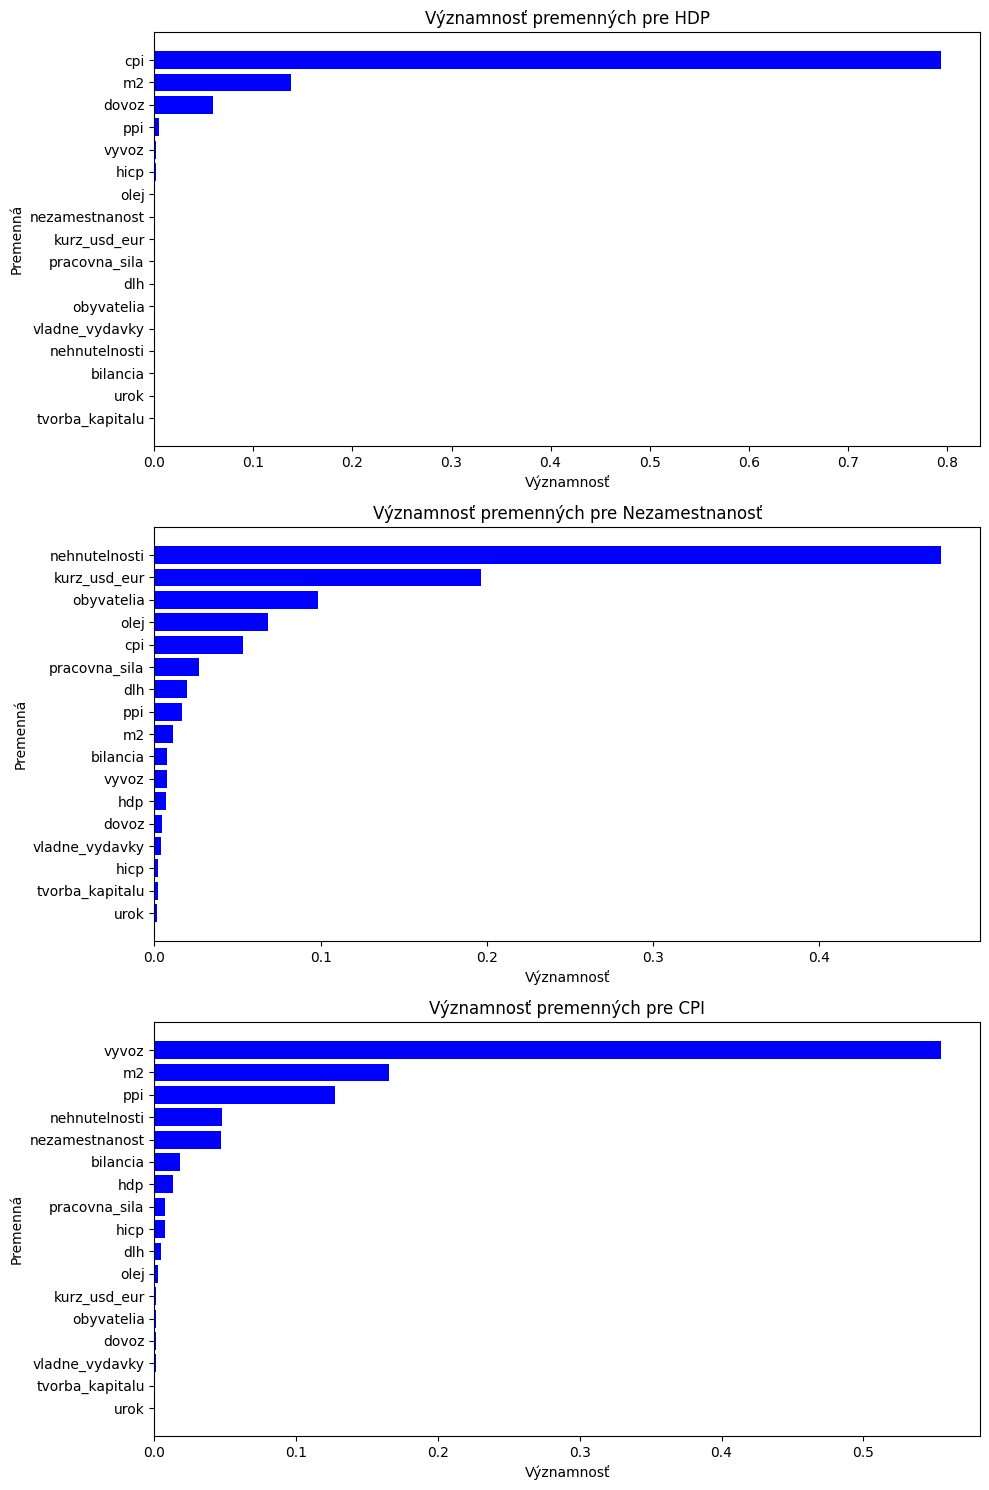

In [7]:
#Významnosť premenných
models = {
    "hdp": best_model_hdp,
    "nezamestnanost": best_model_nezamestnanost,
    "cpi": best_model_cpi
}


feature_importance_results = {}


fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(10, 15))


for idx, (target, model) in enumerate(models.items()):

    
    X = eval(f"X_train_{target}")

    
    importances = model.feature_importances_
    feature_names = X.columns
    
    feature_importance_df = pd.DataFrame({
        "Premenná": feature_names,
        "Významnosť": importances
    }).sort_values(by="Významnosť", ascending=False)

    
    feature_importance_results[target] = feature_importance_df

    if target == "hdp":
        target = "HDP"
    elif target == "cpi":
        target = "CPI"
    else:
        target = "Nezamestnanosť"

    axes[idx].barh(feature_importance_df["Premenná"], feature_importance_df["Významnosť"], color="blue")
    axes[idx].set_xlabel("Významnosť")
    axes[idx].set_ylabel("Premenná")
    axes[idx].set_title(f"Významnosť premenných pre {target}")
    axes[idx].invert_yaxis()


plt.tight_layout()
plt.show()




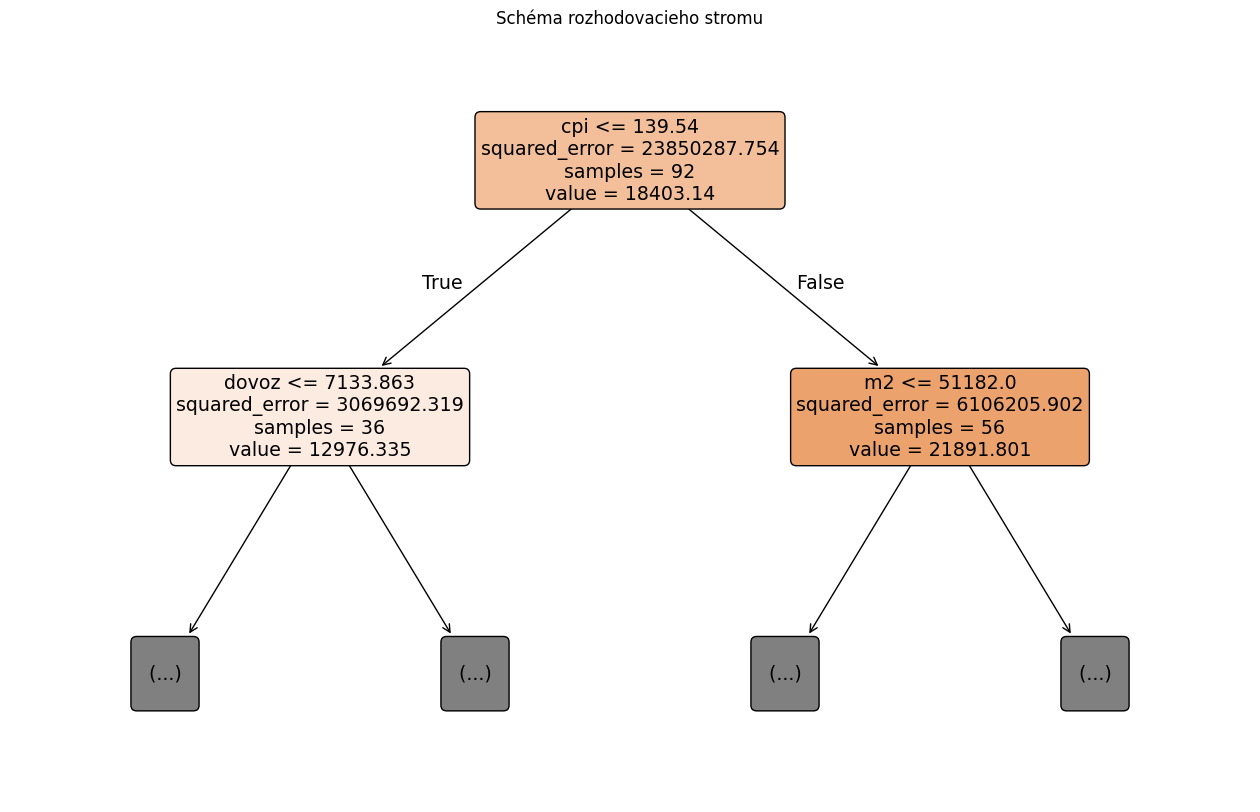

In [12]:
#Diagram rozhodovacieho stromu
plt.figure(figsize=(16, 10))
plot_tree(best_model_hdp, feature_names=X_hdp.columns, filled=True, rounded=True, max_depth=1)
plt.title("Schéma rozhodovacieho stromu")
plt.show()


In [ ]:
#?Významnosť premenných
models = {
    "hdp": best_model_hdp,
    "nezamestnanost": best_model_nezamestnanost,
    "cpi": best_model_cpi
}


feature_importance_results = {}


for target, model in models.items():
    print(f"\nFeature Importance for {target}")

    
    X = df_clean.drop(columns=[target, "stvrtrok"])

    
    importances = model.feature_importances_
    feature_names = X.columns

    
    feature_importance_df = pd.DataFrame({
        "Feature": feature_names,
        "Importance": importances
    }).sort_values(by="Importance", ascending=False)

    
    feature_importance_results[target] = feature_importance_df

    
    print(feature_importance_df)

    
    plt.figure(figsize=(10, 5))
    plt.barh(feature_importance_df["Feature"], feature_importance_df["Importance"], color="blue")
    plt.xlabel("Feature Importance")
    plt.ylabel("Feature")
    plt.title(f"Feature Importance for {target}")
    plt.gca().invert_yaxis()
    plt.show()


